# Step by step Bragg edge fitting with iBeatles

In [1]:
import logging
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from scipy.ndimage import gaussian_filter1d
from ibeatles.app.cli import load_data, load_config
from ibeatles.core.processing.normalization import normalize_data
from ibeatles.core.fitting.binning import get_bin_coordinates, get_bin_transmission
from ibeatles.core.material import get_initial_bragg_edge_lambda
from ibeatles.core.fitting.kropff.fitting import fit_bragg_edge_single_pass
from ibeatles.core.strain.mapping import calculate_strain_mapping
from ibeatles.core.strain.visualization import plot_strain_map_overlay, plot_fitting_results_grid

In [2]:
# Set up a custom handler and formatter
handler = logging.StreamHandler()
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
handler.setLevel(logging.INFO)

# Get the root logger and attach the handler
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [handler]  # Replace existing handlers with the custom handler

## Data Loading

In [3]:
# load config
logging.info("Loading config file")
config_file = "../tests/data/json/demo_config.json"
config = load_config(config_file)
logging.info(config)

# load data
logging.info("Loading data")
data_dict = load_data(config)
logging.info(data_dict.keys())
# make local var for raw data, open beam and spectra data
raw_data_dict = data_dict['raw_data']
open_beam_dict = data_dict['open_beam']
spectra_dict = data_dict['spectra']
logging.info(raw_data_dict.keys())
logging.info(open_beam_dict.keys())
logging.info(spectra_dict.keys())

2024-11-07 11:07:02,915 - INFO - Loading config file
2024-11-07 11:07:02,916 - INFO - Loading configuration: ../tests/data/json/demo_config.json
2024-11-07 11:07:02,918 - INFO - raw_data=RawData(raw_data_dir=PosixPath('/Users/8cz/github.com/iBeatles/tests/data/ibeatles_data/SNS/SNAP/IPTS-26171/shared/mcp_transfer/Inconel_Sample'), raw_data_extension='.fits') open_beam=OpenBeamData(open_beam_data_dir=PosixPath('/Users/8cz/github.com/iBeatles/tests/data/ibeatles_data/SNS/SNAP/IPTS-26171/shared/mcp_transfer/Inconel_OB'), open_beam_data_extension='.fits') spectra_file_path=None normalization=NormalizationConfig(sample_background=[SampleBackground(x0=10, y0=10, width=50, height=50), SampleBackground(x0=0, y0=0, width=3, height=3)], moving_average=MovingAverage(active=True, dimension='2D', size=KernelSize(y=3, x=3), type=<KernelType.box: 'Box'>), processing_order=<ProcessOrder.moving_average_normalization: 'Moving average, Normalization'>) analysis=AnalysisConfig(material=Material(element='N

quick sanity check of the spectrum data

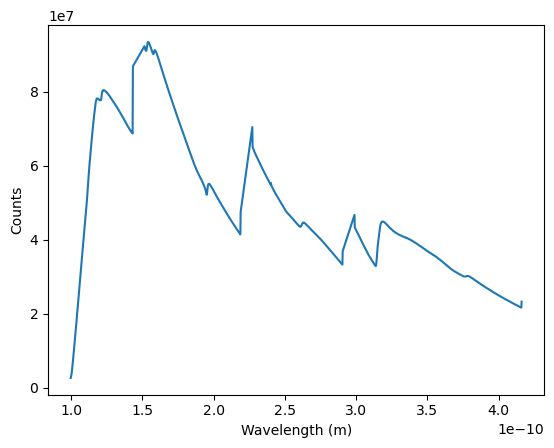

In [4]:
# plot the overall spectra (lambda vs. counts)
lambda_array = spectra_dict["lambda_array"]
counts_array = spectra_dict["counts_array"]

plt.plot(lambda_array, counts_array)
plt.xlabel("Wavelength (m)")
plt.ylabel("Counts")
plt.show()

## Data normalization

We will be using NeuNorm (ibeatles provide a wrapper for NeuNorm) to perform the normalization

In [5]:
normalized_data, output_path = normalize_data(
    sample_data=raw_data_dict["data"],
    ob_data=open_beam_dict["data"],
    time_spectra=spectra_dict,
    config=config,
    output_folder=config.output["normalized_data_dir"],
)

2024-11-07 11:07:13,403 - INFO - Starting normalization process


Loading sample:   0%|          | 0/1435 [00:00<?, ?it/s]

Loading ob:   0%|          | 0/1435 [00:00<?, ?it/s]

2024-11-07 11:07:14,470 - INFO - Applying moving average
2024-11-07 11:07:32,992 - INFO - Performing normalization
2024-11-07 11:07:34,779 - INFO - Copied time spectra file to /Users/8cz/tmp/ibeatles_dev/normalized/Inconel_Sample_normalized/20210910_Run_52256_InconelPowder_0008_0646026_Spectra.txt


Sanity check of the normalized data

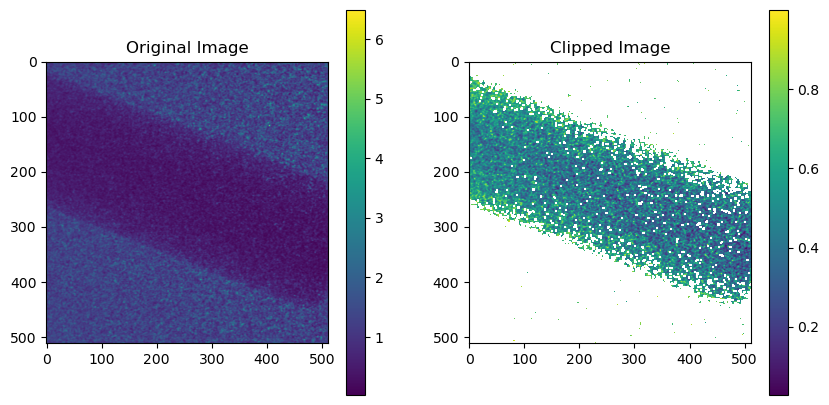

In [6]:
# display original and clipped image
img  = normalized_data[0].T
img_clipped = np.array(img)
img_clipped[img > 1.0] = np.nan

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img, cmap='viridis')
ax[0].set_title("Original Image")
# add colorbar
cbar = plt.colorbar(ax[0].imshow(img, cmap='viridis'), ax=ax[0])
ax[1].imshow(img_clipped, cmap='viridis')
ax[1].set_title("Clipped Image")
# add colorbar
cbar = plt.colorbar(ax[1].imshow(img_clipped, cmap='viridis'), ax=ax[1])

plt.show()

compute the cumulative distribution for the intensity (transmission) values

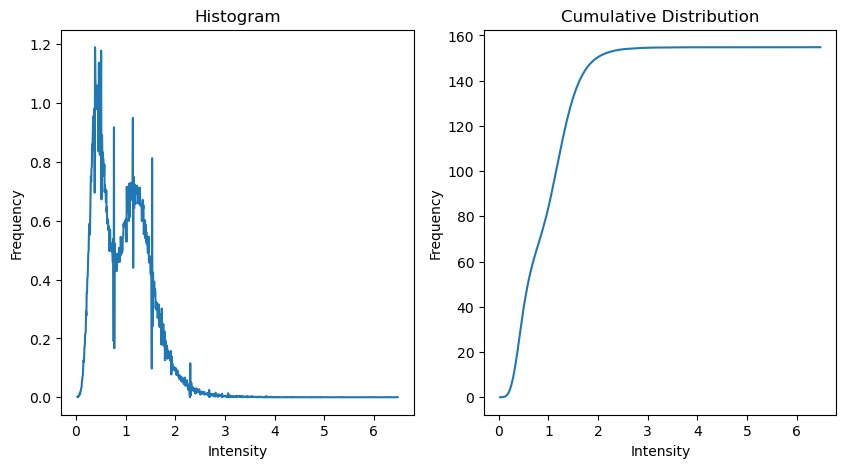

In [7]:
# compute the histogram
hist, bin_edges = np.histogram(img.flatten(), bins=1000, density=True)

# compute the cumulative distribution
cdf = np.cumsum(hist)

# plot the histogram and the cumulative distribution
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(bin_edges[:-1], hist)
ax[0].set_title("Histogram")
ax[0].set_xlabel("Intensity")
ax[0].set_ylabel("Frequency")

ax[1].plot(bin_edges[:-1], cdf)
ax[1].set_title("Cumulative Distribution")
ax[1].set_xlabel("Intensity")
ax[1].set_ylabel("Frequency")

plt.show()

## Kropff fitting to locate the Bragg edge

In [8]:
logging.info(config.analysis.pixel_binning)

2024-11-07 11:07:35,227 - INFO - x0=140 y0=154 width=184 height=150 bins_size=10


In [9]:
bins = get_bin_coordinates(
    image_shape=normalized_data[0].shape,
    **config.analysis.pixel_binning.model_dump(),  # to dict for unpacking
)

Get transmission profile for each bin

In [10]:
wavelengths = spectra_dict["lambda_array"]
lambda_range = config.analysis.fitting.lambda_min, config.analysis.fitting.lambda_max

bin_transmission = {}

for i, bin_coord in enumerate(bins):
    wavelengths_bin, transmission_bin = get_bin_transmission(
        images=normalized_data,
        wavelengths=wavelengths,
        bin_coords=bin_coord,
        lambda_range=None,
    )
    bin_transmission[str(i)] = {
        "wavelengths": wavelengths_bin,
        "transmission": transmission_bin,
        "coordinates": bin_coord
    }

visual inspection of the transmission profiles

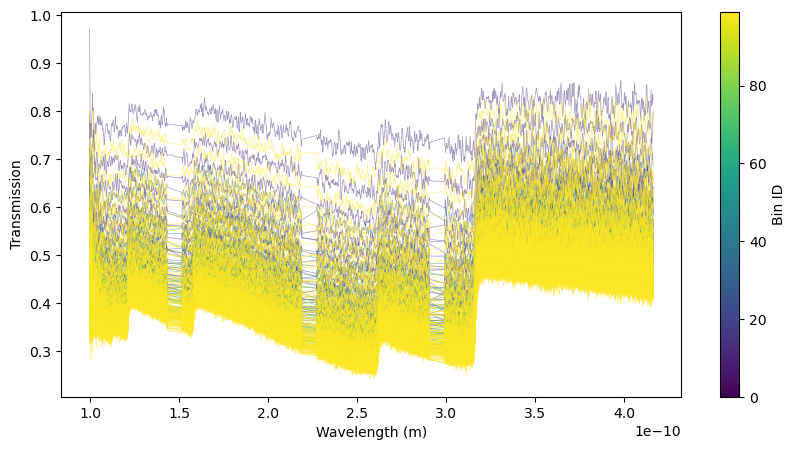

In [11]:
# Normalize the keys for colormap
keys = list(bin_transmission.keys())
norm = mcolors.Normalize(vmin=min(keys), vmax=max(keys))
cmap = cm.viridis

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 5))

# Plot each curve with color from colormap
for key, value in bin_transmission.items():
    key = int(key)  # Convert key to integer
    color = cmap(norm(key))  # Map the key to a color
    ax.plot(
        value["wavelengths"],
        value["transmission"],
        color=color,
        linewidth=0.5,
        alpha=0.5,
    )

# Label axes
ax.set_xlabel("Wavelength (m)")
ax.set_ylabel("Transmission")

# Add color bar with label
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for ScalarMappable
cbar = fig.colorbar(sm, ax=ax)  # Associate color bar with the current axis
cbar.set_label("Bin ID")  # Replace with the appropriate label for your keys

plt.show()

Now let's isolate one bin and perform a manual fitting

/Users/8cz/micromamba/envs/ibeatles/lib/python3.11/site-packages/neutronbraggedge/material_handler/retrieve_material_metadata.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.lattice = float(_metadata[0])
/Users/8cz/micromamba/envs/ibeatles/lib/python3.11/site-packages/neutronbraggedge/material_handler/retrieve_material_metadata.py:71: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  _full_crystal_str = _metadata[1]


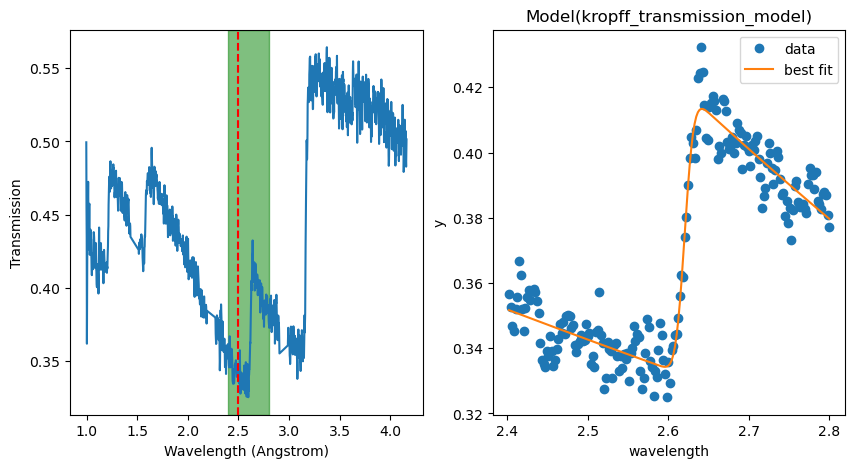

In [12]:
bin_data_0 = bin_transmission["0"]
wavelengths_m = bin_data_0["wavelengths"]
wavelengths_angstrom = wavelengths_m * 1e10
transmission = bin_data_0["transmission"]

# parsing the config
lambda_min_m, lambda_max_m = config.analysis.fitting.lambda_min, config.analysis.fitting.lambda_max
lambda_min_angstrom = lambda_min_m * 1e10
lambda_max_angstrom = lambda_max_m * 1e10

# get the reference (zero strain) Bragg edge value
lambda_range_angstrom = lambda_min_angstrom, lambda_max_angstrom
lambda_0_angstrom = get_initial_bragg_edge_lambda(
    material_config=config.analysis.material,
    lambda_range=lambda_range_angstrom,
)

# fitting
# step_0: need to zoom in to the lambda range as the shape function is not defined outside the range
mask = (wavelengths_angstrom > lambda_min_angstrom) & (wavelengths_angstrom < lambda_max_angstrom)
wavelengths_fitting_angstrom = wavelengths_angstrom[mask]
transmission_fitting = transmission[mask]
# step_1: prepare the initial guess and bounds
initial_parameters = {
    "a0": 0.1,
    "b0": 0.1,
    "a_hkl": 0.1,
    "b_hkl": 0.1,
    "bragg_edge_wavelength": lambda_0_angstrom,  # use the reference Bragg edge as the initial guess
    "sigma": 0.01,
    "tau": 0.01,
}
parameter_bounds = {
    "bragg_edge_wavelength": {
        "min": lambda_min_angstrom,
        "max": lambda_max_angstrom,
    },
    "sigma": {"min": 0.001, "max": 0.1},
    "tau": {"min": 0.001, "max": 0.1},
}
# step_2: fitting
fit_result = fit_bragg_edge_single_pass(
    wavelengths=wavelengths_fitting_angstrom,
    transmission=transmission_fitting,
    initial_parameters=initial_parameters,
    parameter_bounds=parameter_bounds,
)

# viaulization
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# top one shows the full range
ax[0].plot(wavelengths_angstrom, transmission)
# place a block to indicate teh fitting range
ax[0].axvspan(lambda_min_angstrom, lambda_max_angstrom, color='green', alpha=0.5)
# use vertical red line to indicate the reference Bragg edge
ax[0].axvline(x=lambda_0_angstrom, color='red', linestyle='--')
ax[0].set_xlabel("Wavelength (Angstrom)")
ax[0].set_ylabel("Transmission")
# bottom one shows the fitting range
fit_result.plot_fit(ax=ax[1])

plt.show()

# print the fitting result
fit_result


when the data is (relatively) clean with sufficient SNR, the default single pass fitting will work.

However things becomes slightly more complicated when the data is noisy or when the SNR is low, for instance:

/Users/8cz/micromamba/envs/ibeatles/lib/python3.11/site-packages/neutronbraggedge/material_handler/retrieve_material_metadata.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.lattice = float(_metadata[0])
/Users/8cz/micromamba/envs/ibeatles/lib/python3.11/site-packages/neutronbraggedge/material_handler/retrieve_material_metadata.py:71: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  _full_crystal_str = _metadata[1]
2024-11-07 11:07:39,465 - WARNING - Fitting failed: The model function generated NaN values and the fit aborted! Please check your model function and/or set boundaries on parameters where applicable

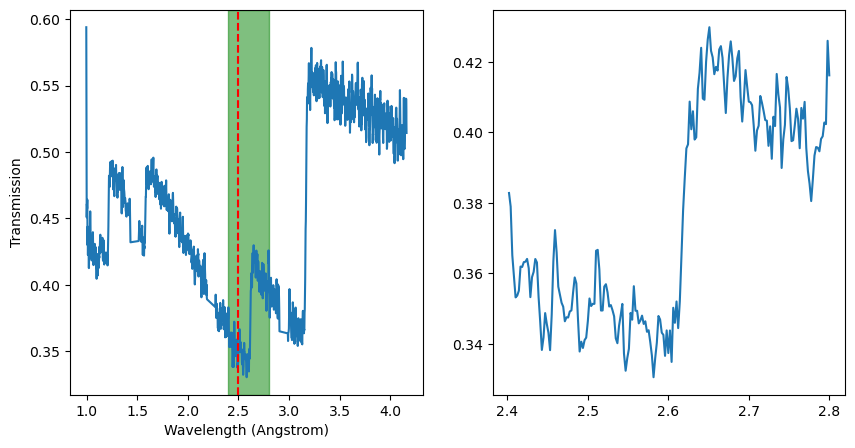

In [13]:
bin_data_0 = bin_transmission["1"]
wavelengths_m = bin_data_0["wavelengths"]
wavelengths_angstrom = wavelengths_m * 1e10
transmission = bin_data_0["transmission"]

# parsing the config
lambda_min_m, lambda_max_m = config.analysis.fitting.lambda_min, config.analysis.fitting.lambda_max
lambda_min_angstrom = lambda_min_m * 1e10
lambda_max_angstrom = lambda_max_m * 1e10

# get the reference (zero strain) Bragg edge value
lambda_range_angstrom = lambda_min_angstrom, lambda_max_angstrom
lambda_0_angstrom = get_initial_bragg_edge_lambda(
    material_config=config.analysis.material,
    lambda_range=lambda_range_angstrom,
)

# fitting
# step_0: need to zoom in to the lambda range as the shape function is not defined outside the range
mask = (wavelengths_angstrom > lambda_min_angstrom) & (wavelengths_angstrom < lambda_max_angstrom)
wavelengths_fitting_angstrom = wavelengths_angstrom[mask]
transmission_fitting = transmission[mask]
# step_1: prepare the initial guess and bounds
initial_parameters = {
    "a0": 0.1,
    "b0": 0.1,
    "a_hkl": 0.1,
    "b_hkl": 0.1,
    "bragg_edge_wavelength": lambda_0_angstrom,  # use the reference Bragg edge as the initial guess
    "sigma": 0.01,
    "tau": 0.01,
}
parameter_bounds = {
    "bragg_edge_wavelength": {
        "min": lambda_min_angstrom,
        "max": lambda_max_angstrom,
    },
    "sigma": {"min": 0.001, "max": 0.1},
    "tau": {"min": 0.001, "max": 0.1},
}
# step_2: fitting
fit_result = fit_bragg_edge_single_pass(
    wavelengths=wavelengths_fitting_angstrom,
    transmission=transmission_fitting,
    initial_parameters=initial_parameters,
    parameter_bounds=parameter_bounds,
)

# viaulization
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# top one shows the full range
ax[0].plot(wavelengths_angstrom, transmission)
# place a block to indicate teh fitting range
ax[0].axvspan(lambda_min_angstrom, lambda_max_angstrom, color='green', alpha=0.5)
# use vertical red line to indicate the reference Bragg edge
ax[0].axvline(x=lambda_0_angstrom, color='red', linestyle='--')
ax[0].set_xlabel("Wavelength (Angstrom)")
ax[0].set_ylabel("Transmission")
# bottom one shows the fitting range
# fit_result.plot_fit(ax=ax[1])
ax[1].plot(wavelengths_fitting_angstrom, transmission_fitting)

plt.show()

# print the fitting result
fit_result


This data is not extremely noisy, but the high frequency noise is making the fitting difficult. Therefore we will have to use a two step fitting approach to deal with this issue.
- step 1: use low-pass filter (Gaussian) to adaptively reach a smooth representation of the data such that an initial guess can be made
- step 2: use the initial guess to perform a single pass fitting with the raw data

/Users/8cz/micromamba/envs/ibeatles/lib/python3.11/site-packages/neutronbraggedge/material_handler/retrieve_material_metadata.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.lattice = float(_metadata[0])
/Users/8cz/micromamba/envs/ibeatles/lib/python3.11/site-packages/neutronbraggedge/material_handler/retrieve_material_metadata.py:71: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  _full_crystal_str = _metadata[1]


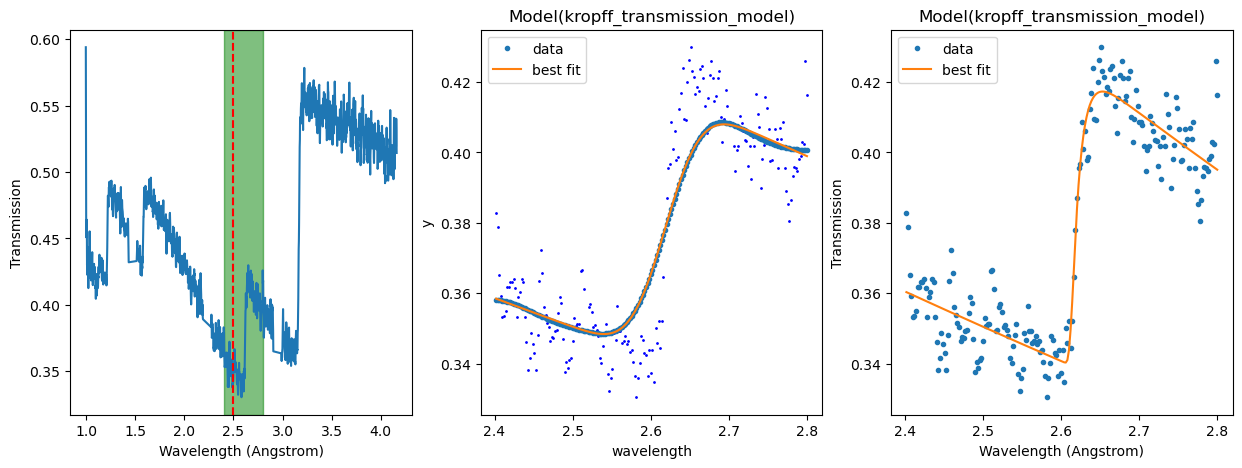

In [14]:
bin_data = bin_transmission["1"]
wavelengths_m = bin_data["wavelengths"]
wavelengths_angstrom = wavelengths_m * 1e10
transmission = bin_data["transmission"]

# parsing the config
lambda_min_m, lambda_max_m = config.analysis.fitting.lambda_min, config.analysis.fitting.lambda_max
lambda_min_angstrom = lambda_min_m * 1e10
lambda_max_angstrom = lambda_max_m * 1e10

# get the reference (zero strain) Bragg edge value
lambda_range_angstrom = lambda_min_angstrom, lambda_max_angstrom
lambda_0_angstrom = get_initial_bragg_edge_lambda(
    material_config=config.analysis.material,
    lambda_range=lambda_range_angstrom,
)

# fitting
# step_0: need to zoom in to the lambda range as the shape function is not defined outside the range
mask = (wavelengths_angstrom > lambda_min_angstrom) & (wavelengths_angstrom < lambda_max_angstrom)
wavelengths_fitting_angstrom = wavelengths_angstrom[mask]
transmission_fitting = transmission[mask]
# step_1: prepare the initial guess and bounds
initial_parameters = {
    "a0": 0.1,
    "b0": 0.1,
    "a_hkl": 0.1,
    "b_hkl": 0.1,
    "bragg_edge_wavelength": lambda_0_angstrom,  # use the reference Bragg edge as the initial guess
    "sigma": 0.01,
    "tau": 0.01,
}
parameter_bounds = {
    "bragg_edge_wavelength": {
        "min": lambda_min_angstrom,
        "max": lambda_max_angstrom,
    },
    "sigma": {"min": 0.001, "max": 0.1},
    "tau": {"min": 0.001, "max": 0.1},
}
# step_2: fitting a smooth curve
# starting with sigma as 15% of the data length, gradually increase if the fitting if failing
ratio = 0.10
fit_success = False
while not fit_success:
    sigma = int(len(transmission_fitting) * ratio)
    transmission_smooth = gaussian_filter1d(transmission_fitting, sigma=sigma)
    fit_result_smoothed = fit_bragg_edge_single_pass(
        wavelengths=wavelengths_fitting_angstrom,
        transmission=transmission_smooth,
        initial_parameters=initial_parameters,
        parameter_bounds=parameter_bounds,
    )
    if fit_result_smoothed is None:
        logging.info(f"Failed fitting with sigma = {sigma}")
        ratio += 0.02
        continue
    else:
        fit_success = True
# step_3: fitting the original data with the smoothed curve as the initial guess
fit_result = fit_bragg_edge_single_pass(
    wavelengths=wavelengths_fitting_angstrom,
    transmission=transmission_fitting,
    initial_parameters=fit_result_smoothed.best_values,
    parameter_bounds=parameter_bounds,
)

# viaulization
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
# left shows the full range
ax[0].plot(wavelengths_angstrom, transmission)
# place a block to indicate teh fitting range
ax[0].axvspan(lambda_min_angstrom, lambda_max_angstrom, color='green', alpha=0.5)
# use vertical red line to indicate the reference Bragg edge
ax[0].axvline(x=lambda_0_angstrom, color='red', linestyle='--')
ax[0].set_xlabel("Wavelength (Angstrom)")
ax[0].set_ylabel("Transmission")
# middle shows the fitting of smoothed curve
fit_result_smoothed.plot_fit(ax=ax[1], datafmt=".")
ax[1].scatter(wavelengths_fitting_angstrom, transmission_fitting, s=1, color='blue', label='original')
# ax[1].plot(wavelengths_fitting_angstrom, transmission_smooth, color='red', label='smoothed')
# right shows the final fitting result
if fit_result is not None:
    fit_result.plot_fit(ax=ax[2], datafmt=".")
else:
    # if the fitting failed, plot the raw data and the smoothed curve
    ax[2].plot(wavelengths_fitting_angstrom, transmission_fitting, color='blue', label='original')
    ax[2].plot(wavelengths_fitting_angstrom, transmission_smooth, color='red', label='smoothed')
ax[2].set_xlabel("Wavelength (Angstrom)")
ax[2].set_ylabel("Transmission")

plt.show()

# fit_result_smoothed
fit_result

and some times we need to auto bump the Gaussian filter kernel to get a good fit

/Users/8cz/micromamba/envs/ibeatles/lib/python3.11/site-packages/neutronbraggedge/material_handler/retrieve_material_metadata.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.lattice = float(_metadata[0])
/Users/8cz/micromamba/envs/ibeatles/lib/python3.11/site-packages/neutronbraggedge/material_handler/retrieve_material_metadata.py:71: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  _full_crystal_str = _metadata[1]
2024-11-07 11:07:39,703 - WARNING - Fitting failed: The model function generated NaN values and the fit aborted! Please check your model function and/or set boundaries on parameters where applicable

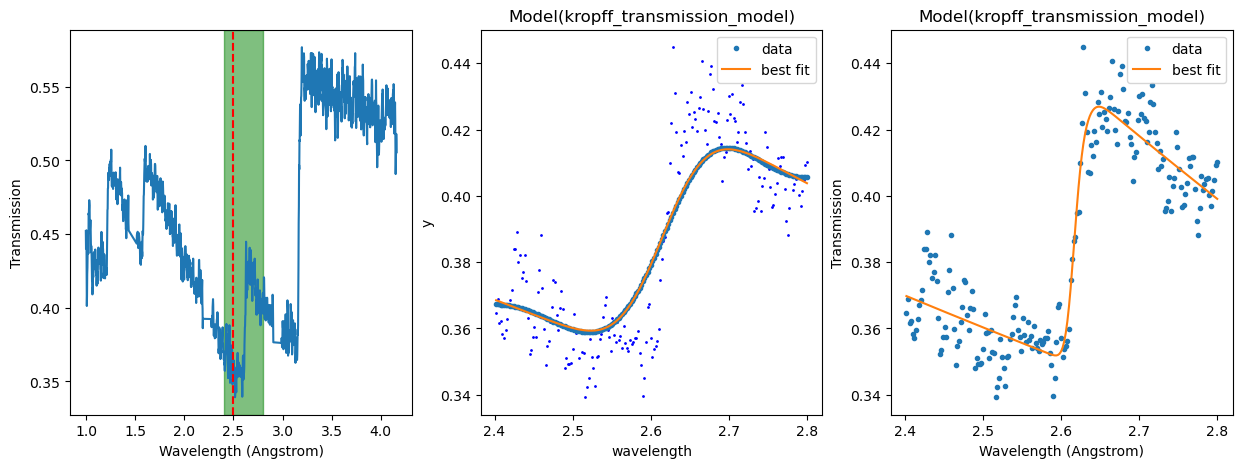

In [15]:
bin_data = bin_transmission["2"]
wavelengths_m = bin_data["wavelengths"]
wavelengths_angstrom = wavelengths_m * 1e10
transmission = bin_data["transmission"]

# parsing the config
lambda_min_m, lambda_max_m = config.analysis.fitting.lambda_min, config.analysis.fitting.lambda_max
lambda_min_angstrom = lambda_min_m * 1e10
lambda_max_angstrom = lambda_max_m * 1e10

# get the reference (zero strain) Bragg edge value
lambda_range_angstrom = lambda_min_angstrom, lambda_max_angstrom
lambda_0_angstrom = get_initial_bragg_edge_lambda(
    material_config=config.analysis.material,
    lambda_range=lambda_range_angstrom,
)

# fitting
# step_0: need to zoom in to the lambda range as the shape function is not defined outside the range
mask = (wavelengths_angstrom > lambda_min_angstrom) & (wavelengths_angstrom < lambda_max_angstrom)
wavelengths_fitting_angstrom = wavelengths_angstrom[mask]
transmission_fitting = transmission[mask]
# step_1: prepare the initial guess and bounds
initial_parameters = {
    "a0": 0.1,
    "b0": 0.1,
    "a_hkl": 0.1,
    "b_hkl": 0.1,
    "bragg_edge_wavelength": lambda_0_angstrom,  # use the reference Bragg edge as the initial guess
    "sigma": 0.01,
    "tau": 0.01,
}
parameter_bounds = {
    "bragg_edge_wavelength": {
        "min": lambda_min_angstrom,
        "max": lambda_max_angstrom,
    },
    "sigma": {"min": 0.001, "max": 0.1},
    "tau": {"min": 0.001, "max": 0.1},
}
# step_2: fitting a smooth curve
# starting with sigma as 15% of the data length, gradually increase if the fitting if failing
ratio = 0.10
fit_success = False
while not fit_success:
    sigma = int(len(transmission_fitting) * ratio)
    transmission_smooth = gaussian_filter1d(transmission_fitting, sigma=sigma)
    fit_result_smoothed = fit_bragg_edge_single_pass(
        wavelengths=wavelengths_fitting_angstrom,
        transmission=transmission_smooth,
        initial_parameters=initial_parameters,
        parameter_bounds=parameter_bounds,
    )
    if fit_result_smoothed is None:
        logging.info(f"Failed fitting with sigma = {sigma}")
        ratio += 0.02
        continue
    else:
        fit_success = True
# step_3: fitting the original data with the smoothed curve as the initial guess
fit_result = fit_bragg_edge_single_pass(
    wavelengths=wavelengths_fitting_angstrom,
    transmission=transmission_fitting,
    initial_parameters=fit_result_smoothed.best_values,
    parameter_bounds=parameter_bounds,
)

# viaulization
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
# left shows the full range
ax[0].plot(wavelengths_angstrom, transmission)
# place a block to indicate teh fitting range
ax[0].axvspan(lambda_min_angstrom, lambda_max_angstrom, color='green', alpha=0.5)
# use vertical red line to indicate the reference Bragg edge
ax[0].axvline(x=lambda_0_angstrom, color='red', linestyle='--')
ax[0].set_xlabel("Wavelength (Angstrom)")
ax[0].set_ylabel("Transmission")
# middle shows the fitting of smoothed curve
fit_result_smoothed.plot_fit(ax=ax[1], datafmt=".")
ax[1].scatter(wavelengths_fitting_angstrom, transmission_fitting, s=1, color='blue', label='original')
# ax[1].plot(wavelengths_fitting_angstrom, transmission_smooth, color='red', label='smoothed')
# right shows the final fitting result
if fit_result is not None:
    fit_result.plot_fit(ax=ax[2], datafmt=".")
else:
    # if the fitting failed, plot the raw data and the smoothed curve
    ax[2].plot(wavelengths_fitting_angstrom, transmission_fitting, color='blue', label='original')
    ax[2].plot(wavelengths_fitting_angstrom, transmission_smooth, color='red', label='smoothed')
ax[2].set_xlabel("Wavelength (Angstrom)")
ax[2].set_ylabel("Transmission")

plt.show()

# fit_result_smoothed
fit_result

unfortunately, some bins has really **low SNR**, even two-step fitting is not sufficient.
In situations like this (should be rare), we accept defeat and move on

/Users/8cz/micromamba/envs/ibeatles/lib/python3.11/site-packages/neutronbraggedge/material_handler/retrieve_material_metadata.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.lattice = float(_metadata[0])
/Users/8cz/micromamba/envs/ibeatles/lib/python3.11/site-packages/neutronbraggedge/material_handler/retrieve_material_metadata.py:71: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  _full_crystal_str = _metadata[1]
2024-11-07 11:07:40,320 - WARNING - Fitting failed: The model function generated NaN values and the fit aborted! Please check your model function and/or set boundaries on parameters where applicable

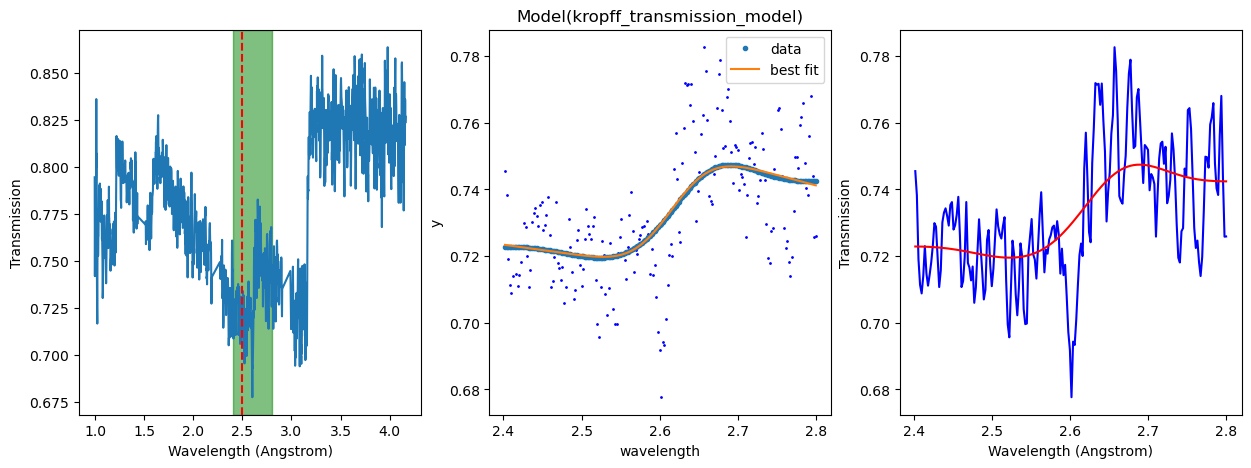

In [16]:
bin_data = bin_transmission["14"]
wavelengths_m = bin_data["wavelengths"]
wavelengths_angstrom = wavelengths_m * 1e10
transmission = bin_data["transmission"]

# parsing the config
lambda_min_m, lambda_max_m = config.analysis.fitting.lambda_min, config.analysis.fitting.lambda_max
lambda_min_angstrom = lambda_min_m * 1e10
lambda_max_angstrom = lambda_max_m * 1e10

# get the reference (zero strain) Bragg edge value
lambda_range_angstrom = lambda_min_angstrom, lambda_max_angstrom
lambda_0_angstrom = get_initial_bragg_edge_lambda(
    material_config=config.analysis.material,
    lambda_range=lambda_range_angstrom,
)

# fitting
# step_0: need to zoom in to the lambda range as the shape function is not defined outside the range
mask = (wavelengths_angstrom > lambda_min_angstrom) & (wavelengths_angstrom < lambda_max_angstrom)
wavelengths_fitting_angstrom = wavelengths_angstrom[mask]
transmission_fitting = transmission[mask]
# step_1: prepare the initial guess and bounds
initial_parameters = {
    "a0": 0.1,
    "b0": 0.1,
    "a_hkl": 0.1,
    "b_hkl": 0.1,
    "bragg_edge_wavelength": lambda_0_angstrom,  # use the reference Bragg edge as the initial guess
    "sigma": 0.01,
    "tau": 0.01,
}
parameter_bounds = {
    "bragg_edge_wavelength": {
        "min": lambda_min_angstrom,
        "max": lambda_max_angstrom,
    },
    "sigma": {"min": 0.001, "max": 0.1},
    "tau": {"min": 0.001, "max": 0.1},
}
# step_2: fitting a smooth curve
# starting with sigma as 15% of the data length, gradually increase if the fitting if failing
ratio = 0.10
fit_success = False
while not fit_success:
    sigma = int(len(transmission_fitting) * ratio)
    transmission_smooth = gaussian_filter1d(transmission_fitting, sigma=sigma)
    fit_result_smoothed = fit_bragg_edge_single_pass(
        wavelengths=wavelengths_fitting_angstrom,
        transmission=transmission_smooth,
        initial_parameters=initial_parameters,
        parameter_bounds=parameter_bounds,
    )
    if fit_result_smoothed is None:
        logging.info(f"Failed fitting with sigma = {sigma}")
        ratio += 0.02
        continue
    else:
        fit_success = True
# step_3: fitting the original data with the smoothed curve as the initial guess
fit_result = fit_bragg_edge_single_pass(
    wavelengths=wavelengths_fitting_angstrom,
    transmission=transmission_fitting,
    initial_parameters=fit_result_smoothed.best_values,
    parameter_bounds=parameter_bounds,
)

# viaulization
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
# left shows the full range
ax[0].plot(wavelengths_angstrom, transmission)
# place a block to indicate teh fitting range
ax[0].axvspan(lambda_min_angstrom, lambda_max_angstrom, color='green', alpha=0.5)
# use vertical red line to indicate the reference Bragg edge
ax[0].axvline(x=lambda_0_angstrom, color='red', linestyle='--')
ax[0].set_xlabel("Wavelength (Angstrom)")
ax[0].set_ylabel("Transmission")
# middle shows the fitting of smoothed curve
fit_result_smoothed.plot_fit(ax=ax[1], datafmt=".")
ax[1].scatter(wavelengths_fitting_angstrom, transmission_fitting, s=1, color='blue', label='original')
# ax[1].plot(wavelengths_fitting_angstrom, transmission_smooth, color='red', label='smoothed')
# right shows the final fitting result
if fit_result is not None:
    fit_result.plot_fit(ax=ax[2], datafmt=".")
else:
    # if the fitting failed, plot the raw data and the smoothed curve
    ax[2].plot(wavelengths_fitting_angstrom, transmission_fitting, color='blue', label='original')
    ax[2].plot(wavelengths_fitting_angstrom, transmission_smooth, color='red', label='smoothed')
ax[2].set_xlabel("Wavelength (Angstrom)")
ax[2].set_ylabel("Transmission")

plt.show()

# fit_result_smoothed
fit_result

Now let's process all the bins

In [17]:
# step_0: prepare the lambda range
lambda_min_angstrom = config.analysis.fitting.lambda_min * 1e10
lambda_max_angstrom = config.analysis.fitting.lambda_max * 1e10
lambda_range_angstrom = lambda_min_angstrom, lambda_max_angstrom
# step_1: get the reference (zero strain) Bragg edge value
lambda_0_angstrom = get_initial_bragg_edge_lambda(
    material_config=config.analysis.material,
    lambda_range=lambda_range_angstrom,
)
# step_2: setup the initial guess and bounds
initial_parameters = {
    "a0": 0.1,
    "b0": 0.1,
    "a_hkl": 0.1,
    "b_hkl": 0.1,
    "bragg_edge_wavelength": lambda_0_angstrom,  # use the reference Bragg edge as the initial guess
    "sigma": 0.01,
    "tau": 0.01,
}
parameter_bounds = {
    "bragg_edge_wavelength": {
        "min": lambda_min_angstrom,
        "max": lambda_max_angstrom,
    },
    "sigma": {"min": 0.001, "max": 0.2},
    "tau": {"min": 0.001, "max": 0.2}
}
# step_3: fitting
fit_results = {}
for key, value in bin_transmission.items():
    wavelengths_angstrom = value["wavelengths"] * 1e10
    transmission = value["transmission"]
    # step_3.1: prepare the fitting range
    mask = (wavelengths_angstrom > lambda_min_angstrom) & (wavelengths_angstrom < lambda_max_angstrom)
    wavelengths_fitting_angstrom = wavelengths_angstrom[mask]
    transmission_fitting = transmission[mask]
    # step_3.2: fitting a smooth version first to get better initial guess
    # NOTE: eventually we will always get a fit for over-smoothed data, so we need to gradually increase the sigma
    #       although the quality of the initial guess decreases with the increase of sigma
    ratio = 0.10
    fit_success = False
    while not fit_success:
        sigma = int(len(transmission_fitting) * ratio)
        transmission_smooth = gaussian_filter1d(transmission_fitting, sigma=sigma)
        fit_result_smoothed = fit_bragg_edge_single_pass(
            wavelengths=wavelengths_fitting_angstrom,
            transmission=transmission_smooth,
            initial_parameters=initial_parameters,
            parameter_bounds=parameter_bounds,
        )
        if fit_result_smoothed is None:
            logging.info(f"Failed fitting with sigma = {sigma}")
            ratio += 0.02
            continue
        else:
            fit_success = True
    # step_3.3: fitting
    fit_result = fit_bragg_edge_single_pass(
        wavelengths=wavelengths_fitting_angstrom,
        transmission=transmission_fitting,
        initial_parameters=fit_result_smoothed.best_values,
        parameter_bounds=parameter_bounds,
    )
    fit_results[key] = fit_result

/Users/8cz/micromamba/envs/ibeatles/lib/python3.11/site-packages/neutronbraggedge/material_handler/retrieve_material_metadata.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.lattice = float(_metadata[0])
/Users/8cz/micromamba/envs/ibeatles/lib/python3.11/site-packages/neutronbraggedge/material_handler/retrieve_material_metadata.py:71: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  _full_crystal_str = _metadata[1]
2024-11-07 11:07:41,538 - WARNING - Fit completed but may not be optimal: Tolerance seems to be too small. Could not estimate error-bars.
2024-11-07 11:07:42,038 - WARNING - Fitting failed: The mode

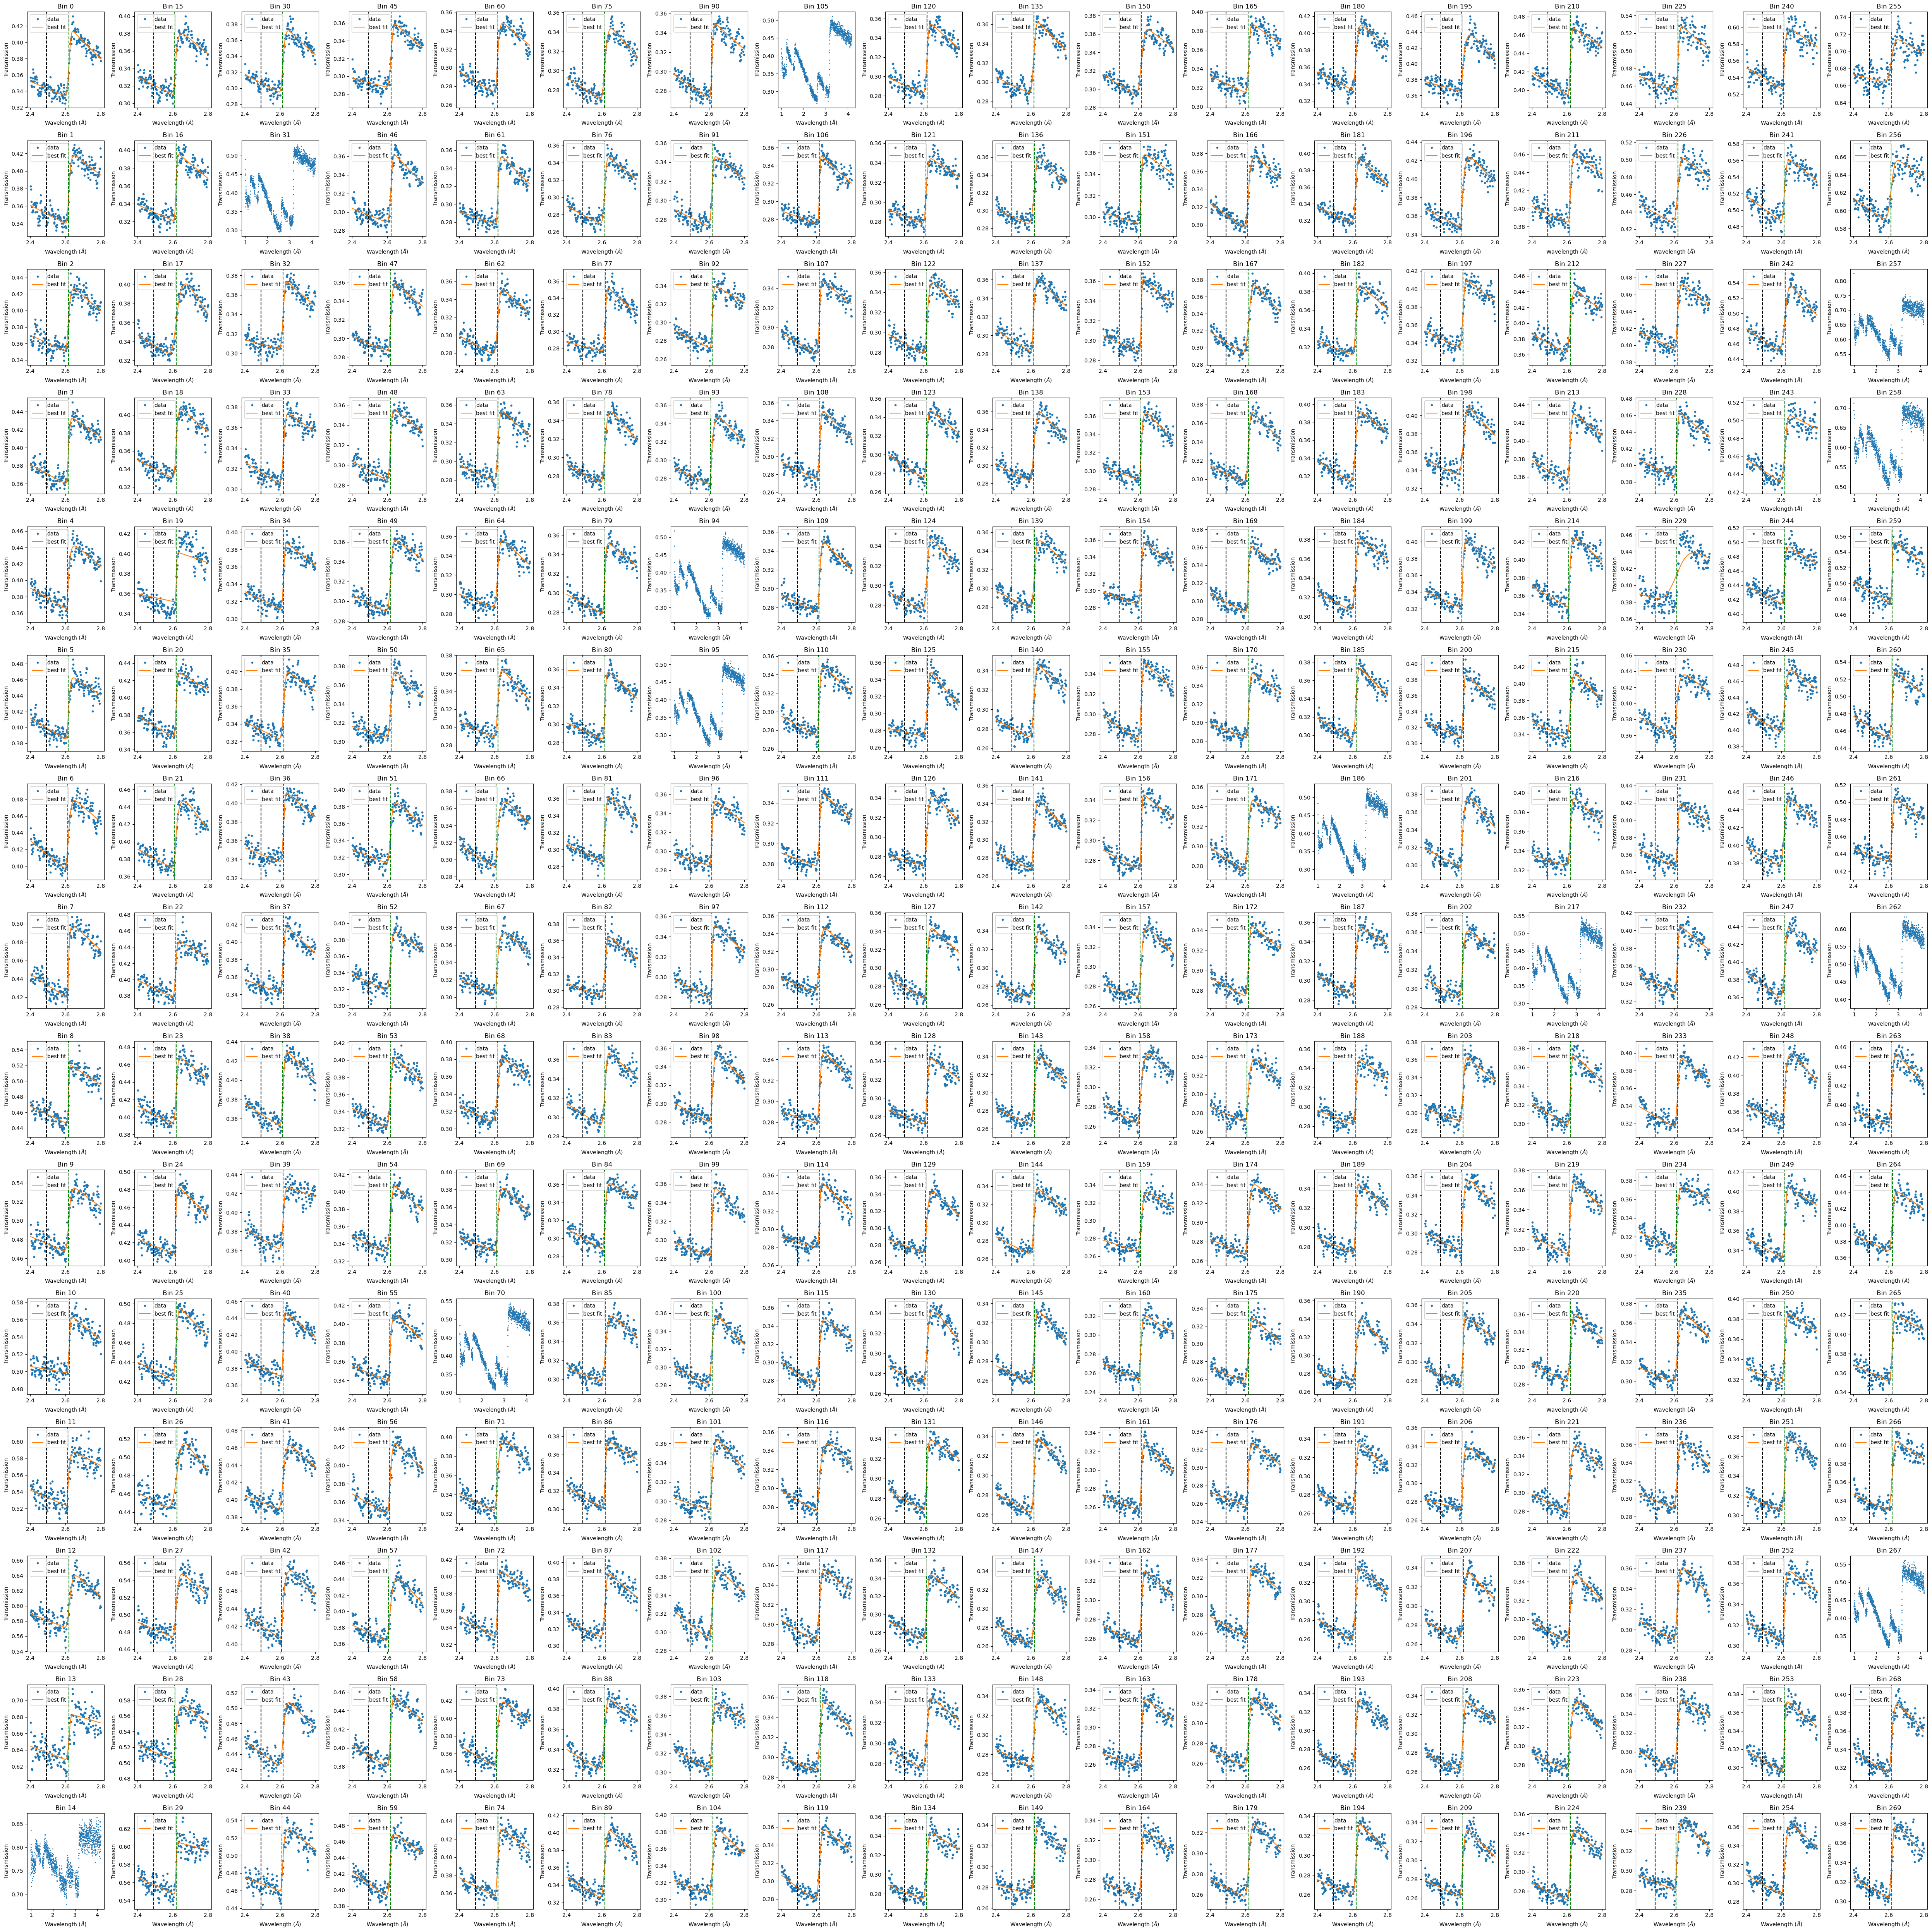

In [18]:
fig, axes = plot_fitting_results_grid(
    fit_results=fit_results,
    bin_transmission=bin_transmission,
    reference_wavelength=lambda_0_angstrom
)
plt.show()

now calculate strain

In [19]:
strain_results = calculate_strain_mapping(
    fit_results=fit_results,
    d0=lambda_0_angstrom,
    quality_threshold=0.8,
)

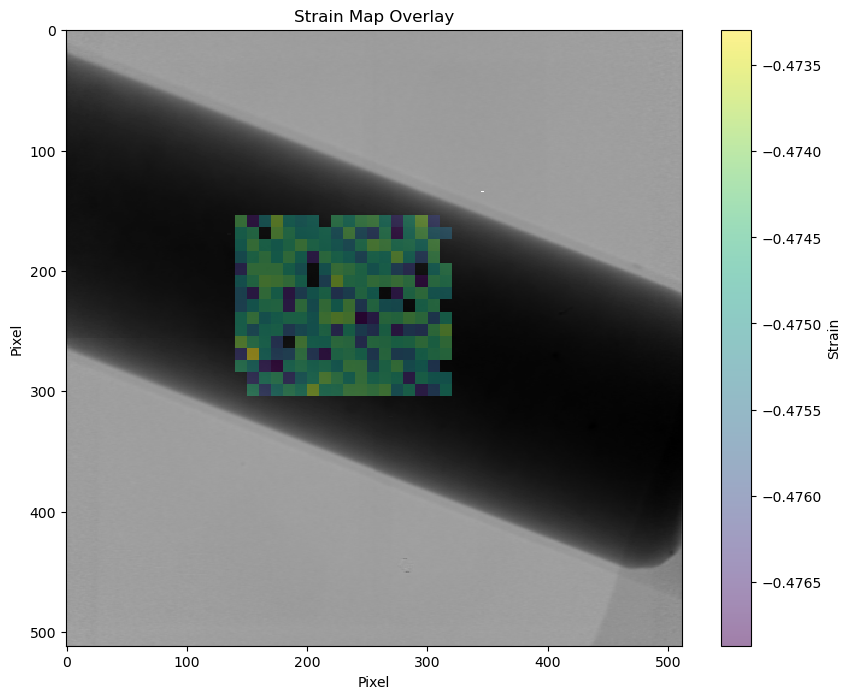

In [20]:
# Create strain map overlay
fig, ax = plot_strain_map_overlay(
    strain_results=strain_results,
    bin_transmission=bin_transmission,
    integrated_image=np.sum(normalized_data, axis=0).T,
    colormap='viridis',
    interpolation='nearest',
    alpha=0.5,
    # vmin=-0.01,
    # vmax=0.01,
)